In [8]:
import os
import pickle

import torch
from torch_geometric.utils import degree
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_dataset
from model import Model as Base

In [3]:
class Model(Base):

    def forward(self, x, edge_index, mask):

        for mp_layer in self.message_passing:
            x = mp_layer(x, edge_index)
            yield x

        out = self.readout(x, mask)
        yield out

In [84]:
EXP_DIR = 'results/smoothing/2024-06-27-16-41-29'
CKPT = 300
SPLIT = 'val'

with open(f'{EXP_DIR}/config.pkl', 'rb') as f:
    config = pickle.load(f)

DEVICE = torch.device(f'cuda:{config.device_index}' if torch.cuda.is_available() and config.device_index is not None else 'cpu')

dataset = get_dataset(config.dataset, config.task, DEVICE)

model = Model(config).to(device=DEVICE)
state_dict = torch.load(f'{EXP_DIR}/ckpt-{CKPT}.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [85]:
model.eval()

with torch.no_grad():
    *representations, logits = model(dataset.x, dataset.edge_index, mask=dataset.test_mask)

dataset.compute_loss(logits, dataset.y[dataset.test_mask])
dataset.compute_metrics()

[('Cross Entropy Loss', 0.5278717041015625),
 ('Accuracy', 0.8379963040351868),
 ('F1 Score', 0.8460693359375),
 ('AU-ROC', 0.9691168665885925)]

In [ ]:
# degrees = degree(dataset.edge_index[0], num_nodes=dataset.train_mask.size(0))

dir_energies, mad_vals = list(), list()

for representation in representations:

    representation = representation / torch.norm(representation, p=2, dim=1, keepdim=True)
    
    pairwise_euclidean = torch.cdist(representation, representation)
    dir_energy = torch.mean(torch.square(pairwise_euclidean))
    dir_energies.append(dir_energy.item())
    
    pairwise_cossim = torch.nn.CosineSimilarity(dim=-1, eps=1e-20)(representation.unsqueeze(0), representation.unsqueeze(1))
    mad = 1 - torch.mean(pairwise_cossim)
    mad_vals.append(mad.item())

plt.plot(range(1, len(dir_energies)+1), dir_energies, color='blue', label='Dirichlet Energy')
plt.plot(range(1, len(mad_vals)+1), mad_vals, color='green', label='MAD')
plt.xlabel('Layer')
plt.ylabel('Oversmoothing')
plt.title('Averaged Over All Node Pairs')
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [ ]:
# degrees = degree(dataset.edge_index[0], num_nodes=dataset.train_mask.size(0))

dir_energies, mad_vals = list(), list()

for representation in representations:

    representation = representation / torch.norm(representation, p=2, dim=1, keepdim=True)
    
    pairwise_euclidean = torch.cdist(representation, representation)
    dir_energy = torch.mean(torch.square(pairwise_euclidean[dataset.edge_index[0], dataset.edge_index[1]]))
    dir_energies.append(dir_energy.item())
    
    pairwise_cossim = torch.nn.CosineSimilarity(dim=-1, eps=1e-20)(representation.unsqueeze(0), representation.unsqueeze(1))
    mad = 1 - torch.mean(pairwise_cossim[dataset.edge_index[0], dataset.edge_index[1]])
    mad_vals.append(mad.item())

plt.plot(range(1, len(dir_energies)+1), dir_energies, color='blue', label='Dirichlet Energy')
plt.plot(range(1, len(mad_vals)+1), mad_vals, color='green', label='MAD')
plt.xlabel('Layer')
plt.ylabel('Oversmoothing')
plt.title('Averaged Over All Edges')
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
plt.show()

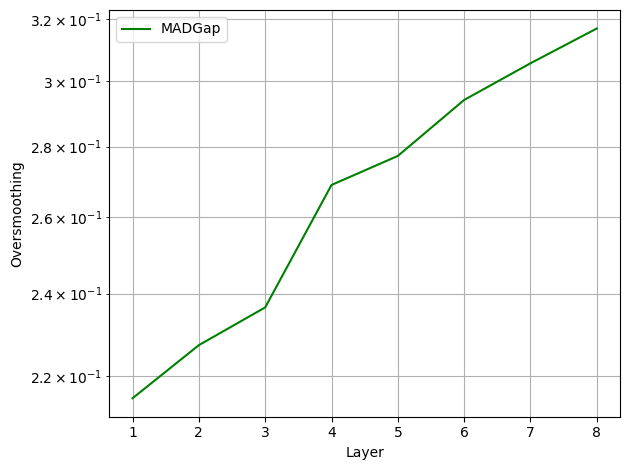

In [111]:
# degrees = degree(dataset.edge_index[0], num_nodes=dataset.train_mask.size(0))

mad_gaps = list()

for representation in representations:

    pairwise_cossim = torch.nn.CosineSimilarity(dim=-1, eps=1e-20)(representation.unsqueeze(0), representation.unsqueeze(1))
    
    mask = torch.zeros(representation.size(0), representation.size(0), dtype=float)
    mask[dataset.edge_index[0], dataset.edge_index[1]] = 1.
    mad_nbr = 1 - torch.mean(torch.sum(pairwise_cossim*mask, dim=1) / torch.sum(mask, dim=1))

    mask = torch.ones(representation.size(0), representation.size(0), dtype=float)
    mask[dataset.edge_index[0], dataset.edge_index[1]] = 0.
    mad_rmt = 1 - torch.mean(torch.sum(pairwise_cossim*mask, dim=1) / torch.sum(mask, dim=1))
    
    mad_gaps.append((mad_rmt-mad_nbr).item())

plt.plot(range(1, len(mad_gaps)+1), mad_gaps, color='green', label='MADGap')
plt.xlabel('Layer')
plt.ylabel('Oversmoothing')
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
plt.show()

# cross-checked with the results using the official implementation
# https://github.com/victorchen96/MadGap/blob/4e49f254bde40b181e749a51dbc7a3abc3153d4c/madgap.py#L13